# ML HW5 sample code
TODO:
 - Complete value iteration algorithm
 - Implement
    1. Greedy action selection
    2. Epsilon-greedy or UCB action selection

Report:
 - Make **2** modifications to encourage the agent to play faster
 - Analyze the public score with and without each modification

In [109]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.animation import PillowWriter, FuncAnimation
import os
from PIL import Image
from tqdm import tqdm

# Define constants
BOARD_SIZE = 8
MAX_ROUNDS = 50
OBSTACLES = {(3, 3), (3, 4), (4, 3), (4, 4), (2,2), (2,5), (5,2), (5,5)}
PAWN_MOVE_PROB = 0.2

# TODO : Define hyperparameters
REWARD_CATCH = 1.0 # 1.0    # Reward for catching the pawn
REWARD_STEP = -0.05 # -0.05        # Cost for each step (time penalty) -0.1, default=0
REWARD_CLOSE = 0         # Reward for getting closer
GAMMA = 0.3 # 0.3             # Discount factor 0.9, default=1
TAU = 0.5  # 0.5              # Learning rate 0.8, default=1
num_episodes = 10000   # 10000

In [110]:
class ChessEnvironment:
    def __init__(self):
        self.reset()

    def reset(self):
        self.knight_pos = self._random_position()
        self.pawn_pos = self._random_position()
        self.rounds = 0
        return self._get_state()

    def _random_position(self):
        while True:
            pos = (random.randint(0, BOARD_SIZE - 1), random.randint(0, BOARD_SIZE - 1))
            if pos not in OBSTACLES:
                return pos

    def _get_state(self):
        if (self.knight_pos == None) | (self.pawn_pos == None):
            print(f"knight_pos: {self.knight_pos}, pawn_pos: {self.pawn_pos}")
            raise ValueError("knight_pos or pawn_pos is None")
        return (*self.knight_pos, *self.pawn_pos)


    def _knight_moves(self, pos):
        x, y = pos
        moves = [
            (x + 2, y + 1), (x + 2, y - 1), (x - 2, y + 1), (x - 2, y - 1),
            (x + 1, y + 2), (x + 1, y - 2), (x - 1, y + 2), (x - 1, y - 2)
        ]
        return [
            (nx, ny) for nx, ny in moves
            if 0 <= nx < BOARD_SIZE and 0 <= ny < BOARD_SIZE and (nx, ny) not in OBSTACLES
        ]

    def step(self, knight_action):
        # Update knight position
        old_distance = abs(self.knight_pos[0] - self.pawn_pos[0]) + abs(self.knight_pos[1] - self.pawn_pos[1])
        self.knight_pos = knight_action

        # Check for termination
        if self.knight_pos == self.pawn_pos:
            return self._get_state(), REWARD_CATCH, True

        # Pawn's random movement
        if random.random() < PAWN_MOVE_PROB:
            px, py = self.pawn_pos
            if px < BOARD_SIZE - 1 and (px + 1, py) not in OBSTACLES:
                self.pawn_pos = (px + 1, py)
        new_distance = abs(self.knight_pos[0] - self.pawn_pos[0]) + abs(self.knight_pos[1] - self.pawn_pos[1])
        self.rounds += 1
        done = self.rounds >= MAX_ROUNDS
        # Reward shaping: Give a small reward for getting closer
        if new_distance <= old_distance:
            return self._get_state(), REWARD_STEP + REWARD_CLOSE, done

        return (self._get_state()), REWARD_STEP, done

In [111]:
def greedy_action_selection(env, state, value_table):
    # Find the action with the highest value
    actions = env._knight_moves(state[:2]) # -> List[(knight_x, knight_y)]
    pawn_cur_pos = state[2:]
    max_value = -float('inf')  # Initialize to negative infinity
    best_actions = []
    action = None
    for a in actions:
        if value_table[(*a, *pawn_cur_pos)] > max_value:
            max_value = value_table[(*a, *pawn_cur_pos)]
            action = a
        # if value_table[(*a, *pawn_cur_pos)] > max_value:
        #     max_value = value_table[(*a, *pawn_cur_pos)]
        #     best_actions = [a]
        # elif value_table[(*a, *pawn_cur_pos)] == max_value:
        #     best_actions.append(a)
    return action

def epsilon_greedy_action_selection(env, state, value_table, epsilon = 0.4):
    # TODO : With probability epsilon, take a random action
    actions = env._knight_moves(state[:2]) # -> List[(knight_x, knight_y)]
    pawn_cur_pos = state[2:]
    if random.random() < epsilon:
        return random.choice(actions)  # Explore
    else:
        max_value = -float('inf')
        best_actions = []
        for a in actions:
            value = value_table[(*a, *pawn_cur_pos)]
            if value > max_value:
                max_value = value
                best_actions = [a]  # Start a new list of best actions
            elif value == max_value:
                best_actions.append(a)  # Add to the list of best actions
    return random.choice(best_actions)  # Exploit (choose randomly among best)

def ucb_action_selection(env, state, value_table, count_table, c=2):
    # TODO : Implement UCB action selection
    actions = env._knight_moves(state[:2]) # -> List[(knight_x, knight_y)]
    pawn_cur_pos = state[2:]

    total_visits = np.sum(count_table[(*state[:2], *pawn_cur_pos)]) + 1e-6  # Total visits to current state

    max_ucb = -float('inf')
    best_actions = []
    # Calculate UCB for all actions before selecting one

    for a in actions:
        visits = count_table[(*a, *pawn_cur_pos)] + 1e-6
        ucb = value_table[(*a, *pawn_cur_pos)] + c * np.sqrt(np.log(total_visits) / visits)

        if ucb > max_ucb:
            max_ucb = ucb
            best_actions = [a]
        elif ucb == max_ucb:
            best_actions.append(a)

    return random.choice(best_actions) if best_actions else random.choice(actions)

# Tabular RL
def train_agent():
    env = ChessEnvironment()
    value_table = np.zeros((BOARD_SIZE, BOARD_SIZE, BOARD_SIZE, BOARD_SIZE)) # state = (knight_x, knight_y, pawn_x, pawn_y)
    count_table = np.zeros((BOARD_SIZE, BOARD_SIZE, BOARD_SIZE, BOARD_SIZE)) # state = (knight_x, knight_y, pawn_x, pawn_y)
    score_table = [i for i in range(num_episodes)]
    for episode in tqdm(range(num_episodes)):
        state = env.reset()
        done = False
        round_counter = 0
        while not done:
            # greedy:
            # action = greedy_action_selection(env, state, value_table)
            # epsilon-greedy:
            # action = epsilon_greedy_action_selection(env, state, value_table, episode)
            # UCB:
            action = ucb_action_selection(env, state, value_table, count_table, c=2) #3

            # Take the action
            next_state, reward, done = env.step(action) # reward = r(s, action)

            # Compute source value
            next_actions = env._knight_moves(next_state[:2]) # -> List[(knight_x, knight_y)]
            max_next_value = max([value_table[(*next_action, *next_state[2:])] for next_action in next_actions]) # greedy
            max_next_value = reward + (GAMMA * max_next_value) # E[r(s,a) + GAMMMA V(s')]

            min_TAU = 0.1
            # Update the value table (You can use hard update or soft update)
            cur_TAU = (TAU - min_TAU) * max(0, 1 - episode/(2*num_episodes)) + min_TAU
            value_table[state] = cur_TAU * max_next_value + ((1 - cur_TAU) * value_table[state])
            # Update the count table
            count_table[state] += 1

            state = next_state
            round_counter += 1
        score_table[episode] = 100 - round_counter

    return value_table, count_table, score_table


In [112]:
# Helper functions
def finish_game(value_table, env):
    # Generate frames of a complete game with progress bar.
    state = env._get_state()
    frames = []
    done = False
    step = 0
    while not done:
        frames.append((*state, step))
        action = greedy_action_selection(env, state, value_table)
        next_state, _, done = env.step(action)
        state = next_state
        step += 1
    frames.append((*state, step))
    return frames

def render_frame(kx, ky, px, py, step, max_steps):
    fig, ax = plt.subplots(figsize=(6, 7))  # Add extra space for the progress bar

    # Plot the chessboard
    ax.set_xlim(0, BOARD_SIZE-1)
    ax.set_ylim(0, BOARD_SIZE-1)
    ax.set_xticks(range(BOARD_SIZE))
    ax.set_yticks(range(BOARD_SIZE))
    ax.grid(True)

    # Draw the obstacles at the center of grid cells
    for x, y in OBSTACLES:
        ax.text(y, BOARD_SIZE - 1 - x, "O", ha="center", va="center", fontsize=20, color="black")

    # Draw the knight at the center of its grid cell
    ax.text(ky, BOARD_SIZE - 1 - kx, "K", ha="center", va="center", fontsize=20, color="blue")

    # Draw the pawn at the center of its grid cell
    ax.text(py, BOARD_SIZE - 1 - px, "P", ha="center", va="center", fontsize=20, color="red")

    # Add a title
    ax.set_title("Catch the Pawn")

    # Add a progress bar below the chessboard
    bar_ax = fig.add_axes([0.1, 0.05, 0.8, 0.05])  # [left, bottom, width, height]
    bar_ax.barh(0, width=step / (max_steps-1), height=1, color="green")
    bar_ax.set_xlim(0, 1)
    bar_ax.axis("off")
    bar_ax.text(0.5, 0, f"Step: {step}/{max_steps-1}", ha="center", va="center", fontsize=12, color="white")

    # Convert the figure to a PIL image
    fig.canvas.draw()
    width, height = fig.canvas.get_width_height()
    img = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8').reshape(height, width, 3)
    pil_img = Image.fromarray(img)

    plt.close(fig)
    return pil_img

def fig_to_array(fig):
    fig.canvas.draw()
    width, height = fig.canvas.get_width_height()
    return np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8').reshape(height, width, 3)

def save_gif(frames, filename="game.gif"):
    frames[0].save(
        filename, save_all=True, append_images=frames[1:]+frames[-1:]*3, duration=500, loop=0
    )


In [113]:
# Train the agent
random.seed(42)
value_table, count_table, score_table = train_agent()


  0%|          | 0/10000 [00:00<?, ?it/s]<ipython-input-111-d2ea5adbdd9c>:50: RuntimeWarning: invalid value encountered in sqrt
  ucb = value_table[(*a, *pawn_cur_pos)] + c * np.sqrt(np.log(total_visits) / visits)
100%|██████████| 10000/10000 [00:04<00:00, 2436.38it/s]


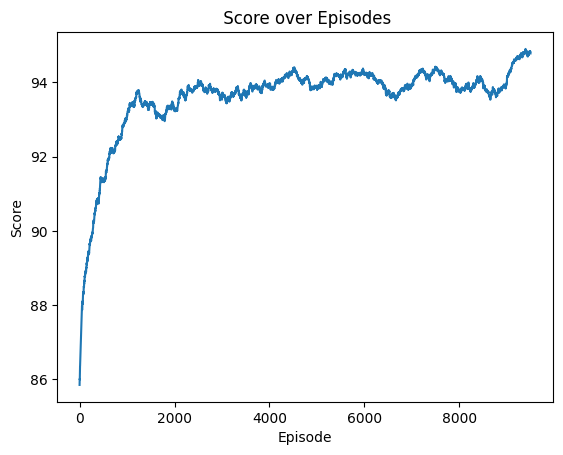

In [114]:
# prompt: plot score_table(a list) as line plot x axis be list index y axis be values(score)
def plot_score_table(score_table, title_text = ""):
    window_size = 500
    moving_avg = np.convolve(score_table, np.ones(window_size), 'valid') / window_size
    plt.plot(range(len(moving_avg)), moving_avg)
    plt.xlabel("Episode")
    plt.ylabel("Score")
    plt.title(f"{title_text} Score over Episodes")
    plt.show()

plot_score_table(score_table)

### Demo

<ipython-input-112-5b615ac86c33>:50: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  img = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8').reshape(height, width, 3)


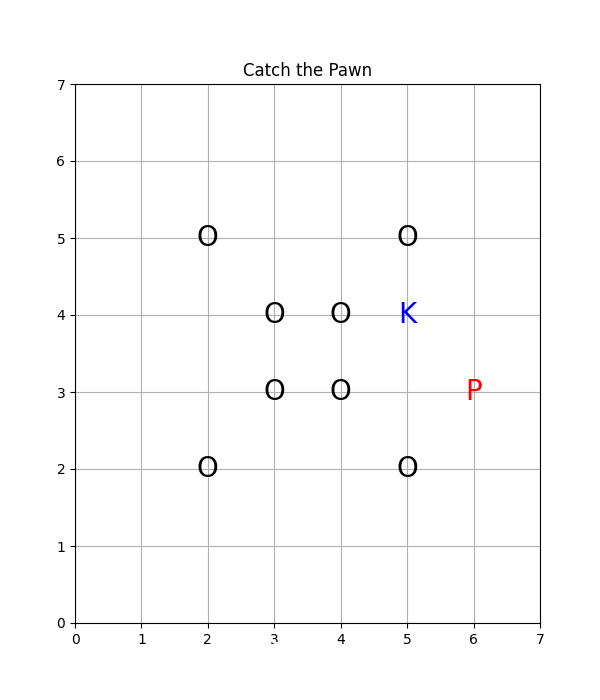

In [115]:
import IPython
# Create game frames and save as gif
env = ChessEnvironment()
# env.reset2()
frames = finish_game(value_table, env)

# save_gif(frames)
save_gif([render_frame(*f, len(frames)) for f in frames])
IPython.display.Image(filename="game.gif")

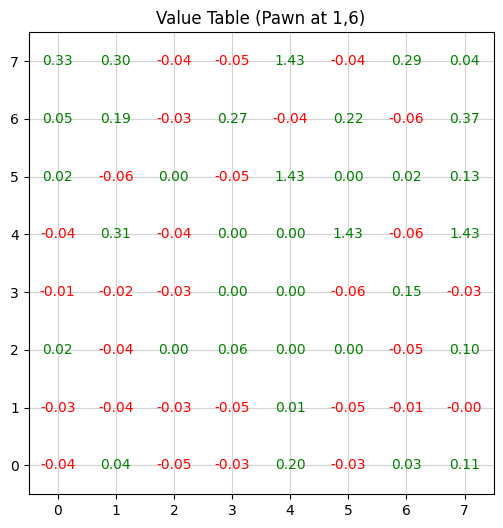

In [116]:
# prompt: plot value table in grid way, with left down be (0,0)
def plot_value_table(value_table, pawn_x, pawn_y):
    # Assuming value_table is a 4D numpy array
    # with dimensions (knight_x, knight_y, pawn_x, pawn_y)

    # Extract dimensions
    board_size = value_table.shape[0]

    # Create a figure and axes
    fig, ax = plt.subplots(figsize=(6, 6))

    # Create a grid for plotting
    x = range(board_size)
    y = range(board_size)
    X, Y = np.meshgrid(x, y)

    # Plot values for different knight positions
    for kx in range(board_size):
        for ky in range(board_size):
            value = value_table[kx, ky, pawn_x, pawn_y]  # Access the value
            if value >= 0:
                color = 'green'
            elif value < 0:
                color = 'red'

            plt.text(ky, board_size - 1 - kx, f'{value:.2f}', ha='center', va='center', color=color)


    # Customize plot appearance (optional)
    ax.set_xlim(-0.5, board_size - 0.5)
    ax.set_ylim(-0.5, board_size - 0.5)
    ax.set_xticks(x)
    ax.set_yticks(y)
    ax.grid(True, which='both', color='lightgray', linestyle='-')
    plt.title(f"Value Table (Pawn at {pawn_x},{pawn_y})")

    plt.show()

# Example usage (assuming 'value_table' is defined)
plot_value_table(value_table, 1, 6)

In [117]:
_x = 3
_y = 6
print(np.round(value_table[:, :, _x, _y], 2))
print(count_table[:, :, _x, _y])

[[ 0.24 -0.06  0.07 -0.01  0.27 -0.02  0.25 -0.04]
 [-0.04  0.11 -0.05  0.22  0.01  1.43 -0.04  1.43]
 [ 0.04 -0.05  0.   -0.03  1.43  0.    0.09 -0.04]
 [-0.04 -0.03 -0.05  0.    0.    0.25 -0.06  0.15]
 [ 0.19 -0.05 -0.02  0.    0.   -0.01  0.33 -0.03]
 [-0.05  0.02  0.    0.02 -0.01  0.   -0.05  1.43]
 [-0.03 -0.03 -0.04 -0.04  0.3  -0.01 -0.   -0.02]
 [-0.03 -0.05 -0.02  0.33  0.05  0.02 -0.05  0.07]]
[[ 9. 12. 14.  8.  8. 19. 11. 18.]
 [14. 11. 14. 11. 19. 47. 16. 19.]
 [13. 13.  0. 15. 43.  0. 17. 17.]
 [14. 15. 14.  0.  0. 14.  4. 12.]
 [11. 14. 15.  0.  0. 23. 17. 17.]
 [15. 16.  0. 15. 19.  0. 17. 47.]
 [14. 16. 15. 16. 17. 19. 13. 19.]
 [13. 15. 15. 13. 18. 15. 15. 13.]]


# Testing
**Submit your value_table.npy to Cool**

In [118]:
# Save the value table
np.save("value_table.npy", value_table)

# # Load the value table
# value_table = np.load("value_table.npy")

### Evaluate on the Public cases

In [119]:
# 100 public states
public_states = [(1, 7, 7, 5), (6, 7, 7, 2), (6, 2, 6, 2), (1, 1, 1, 5), (2, 1, 1, 1), (4, 2, 1, 6), (5, 7, 5, 3), (5, 4, 1, 0), (6, 5, 2, 3), (2, 4, 1, 0), (3, 6, 5, 7), (0, 3, 1, 3), (0, 7, 5, 3), (3, 5, 1, 5), (2, 1, 7, 5), (1, 5, 1, 6), (1, 2, 6, 6), (7, 5, 4, 2), (6, 7, 7, 4), (2, 6, 7, 6), (7, 3, 7, 5), (0, 6, 7, 6), (6, 5, 1, 4), (2, 6, 2, 1), (3, 2, 6, 4), (0, 3, 2, 4), (7, 2, 5, 1), (3, 6, 1, 0), (6, 4, 0, 3), (6, 1, 5, 3), (5, 4, 4, 1), (7, 7, 1, 6), (4, 7, 5, 4), (5, 6, 0, 4), (2, 6, 0, 3), (7, 0, 1, 4), (6, 4, 1, 4), (0, 2, 3, 0), (4, 6, 1, 0), (1, 1, 7, 4), (1, 4, 6, 2), (1, 2, 4, 1), (4, 7, 0, 1), (5, 4, 2, 6), (6, 4, 6, 0), (2, 1, 1, 5), (5, 3, 2, 6), (6, 7, 2, 0), (6, 3, 0, 6), (6, 1, 3, 7), (5, 7, 1, 3), (0, 6, 1, 6), (0, 6, 6, 2), (4, 1, 1, 5), (7, 1, 3, 2), (7, 6, 1, 3), (1, 7, 1, 4), (5, 6, 1, 1), (5, 1, 6, 2), (0, 4, 2, 1), (0, 2, 1, 4), (6, 1, 7, 4), (7, 3, 3, 5), (3, 5, 6, 7), (0, 4, 6, 1), (2, 1, 7, 2), (0, 1, 5, 3), (4, 7, 3, 1), (7, 7, 4, 0), (4, 7, 2, 3), (1, 4, 1, 1), (1, 2, 1, 0), (6, 4, 0, 0), (7, 3, 1, 1), (2, 4, 1, 7), (2, 0, 4, 5), (7, 1, 5, 4), (1, 5, 1, 5), (1, 7, 2, 1), (7, 4, 3, 7), (6, 4, 2, 0), (4, 2, 6, 1), (3, 0, 0, 6), (4, 2, 0, 6), (2, 6, 6, 7), (2, 6, 7, 5), (2, 3, 3, 2), (7, 1, 3, 6), (2, 1, 6, 5), (2, 7, 7, 5), (7, 4, 7, 4), (4, 6, 6, 5), (2, 1, 2, 1), (2, 1, 5, 0), (1, 0, 0, 1), (5, 0, 3, 5), (0, 0, 3, 5), (6, 3, 0, 3), (4, 5, 6, 4), (1, 7, 3, 1)]

# Eval environment (score = 100 - rounds)
class EvalEnvironment:
    def __init__(self):
        self.reset()

    def reset(self):
        self.knight_pos = self._random_position()
        self.pawn_pos = self._random_position()
        self.rounds = 0
        return self._get_state()

    def set_state(self, state):
        """Set the state of the game."""
        self.knight_pos, self.pawn_pos = state[:2], state[2:]
        self.rounds = 0
        return self._get_state()

    def _random_position(self):
        while True:
            pos = (random.randint(0, BOARD_SIZE - 1), random.randint(0, BOARD_SIZE - 1))
            if pos not in OBSTACLES:
                return pos

    def _get_state(self):
        return (*self.knight_pos, *self.pawn_pos)

    def _knight_moves(self, pos):
        x, y = pos
        moves = [
            (x + 2, y + 1), (x + 2, y - 1), (x - 2, y + 1), (x - 2, y - 1),
            (x + 1, y + 2), (x + 1, y - 2), (x - 1, y + 2), (x - 1, y - 2)
        ]
        return [
            (nx, ny) for nx, ny in moves
            if 0 <= nx < BOARD_SIZE and 0 <= ny < BOARD_SIZE and (nx, ny) not in OBSTACLES
        ]

    def step(self, knight_action):
        # Update knight position
        self.knight_pos = knight_action

        # Check for termination
        if self.knight_pos == self.pawn_pos:
            return self._get_state(), 100-self.rounds, True

        # Pawn's random movement
        if random.random() < PAWN_MOVE_PROB:
            px, py = self.pawn_pos
            if px < BOARD_SIZE - 1 and (px + 1, py) not in OBSTACLES:
                self.pawn_pos = (px + 1, py)

        self.rounds += 1
        done = self.rounds >= MAX_ROUNDS
        return (self._get_state()), 0, done

def finish_game_eval(value_table, env):
    # Finish the game and get the score
    state = env._get_state()
    done = False
    while not done:
        action = greedy_action_selection(env, state, value_table)
        state, score, done = env.step(action)
    return score

In [120]:
# Evaluate the value table
env = EvalEnvironment()

# fix the random seed (TA will use this seed)
random.seed(42)

# run the public cases
scores = []
for state in public_states:
    env.set_state(state)
    score = finish_game_eval(value_table, env)
    scores.append(score)
print(f"Public score: {sum(scores)/len(scores)}")

Public score: 86.13


Tuning Hyper-parameters

  0%|          | 0/10000 [00:00<?, ?it/s]<ipython-input-64-164ff7f324ba>:50: RuntimeWarning: invalid value encountered in sqrt
  ucb = value_table[(*a, *pawn_cur_pos)] + c * np.sqrt(np.log(total_visits) / visits)
100%|██████████| 10000/10000 [00:02<00:00, 3634.28it/s]


Public score: 91.08


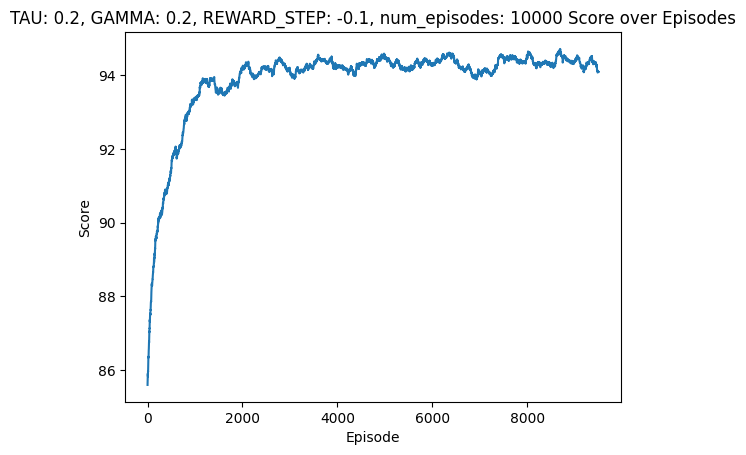

 46%|████▌     | 13826/30000 [00:04<00:05, 2815.22it/s]


KeyboardInterrupt: 

In [ ]:
random.seed(42)
env = EvalEnvironment()
best_scroe =0
for t in [0.2, 0.4, 0.5]:
  for g in [0.2, 0.3, 0.5]:
    for penalty in [-0.1, -0.05, -0.01]:
      for n in [10000, 30000, 50000, 100000]:
        TAU = t
        GAMMA = g
        REWARD_STEP = penalty
        num_episodes = n
        text = f"TAU: {TAU}, GAMMA: {GAMMA}, REWARD_STEP: {REWARD_STEP}, num_episodes: {num_episodes}"
        value_table, count_table, score_table = train_agent()
        # run the public cases
        scores = []
        for state in public_states:
            env.set_state(state)
            score = finish_game_eval(value_table, env)
            scores.append(score)
        print(f"Public score: {sum(scores)/len(scores)}")
        if sum(scores)/len(scores)> best_scroe:
          plot_score_table(score_table, text)
          best_scroe = sum(scores)/len(scores)
          best_TAU = TAU
          best_GAMMA = GAMMA
          best_REWARD_STEP = REWARD_STEP
          best_num_episodes = num_episodes
          best_vt = value_table
          np.save("value_table.npy", value_table)
value_table = best_vt

In [ ]:
print(f'GAMMA:{best_GAMMA}, TAU:{best_TAU}, reward_step:{best_REWARD_STEP}, n:{best_num_episodes}')

### Evaluation

In [ ]:
# Evaluate the value table
env = EvalEnvironment()

# fix the random seed (TA will use this seed)
random.seed(42)

# run the public cases
scores = []
for state in public_states:
    env.set_state(state)
    score = finish_game_eval(value_table, env)
    scores.append(score)
print(f"Public score: {sum(scores)/len(scores)}")